<a href="https://colab.research.google.com/github/nickchak21/QuarkGluonClassifiers/blob/master/Executable_Colab_Notebooks/CMS_particle_distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing the energyflow and h5py packages in the Colab environment

In [1]:
!pip install energyflow
!pip install h5py

     |████████████████████████████████| 696kB 4.8MB/s 
     |████████████████████████████████| 2.9MB 22.6MB/s 
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0


Checking the version of Python (should be Python 3.6)

In [2]:
!python --version

Python 3.6.9


Installing POT (Python Optimal Transform) package

In [3]:
!pip install POT

     |████████████████████████████████| 307kB 4.8MB/s 


In [4]:
%tensorflow_version 1.x #specifies that we want to use TensorFlow 1 (the default on Colab is going to switch soon)

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.x #specifies that we want to use TensorFlow 1 (the default on Colab is going to switch soon)`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Import all necessary packages

In [5]:
# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, remap_pids, to_categorical

# attempt to import sklearn
try:
    from sklearn.metrics import roc_auc_score, roc_curve
except:
    print('please install scikit-learn in order to make ROC curves')
    roc_curve = False

# attempt to import matplotlib
try:
    import matplotlib.pyplot as plt
except:
    print('please install matplotlib in order to make plots')
    plt = False


Using TensorFlow backend.


Load particle distribution from CMS Open Data

In [7]:
# load data
specs = ['375 <= corr_jet_pts <= 425', 'abs_jet_eta < 1.9', 'quality >= 2']
amount = 1.0
cms = ef.mod.load(*specs, dataset='cms', amount=amount)
print("Number of jets: ", len(cms))

print("Max: ", np.amax(cms.jet_ms))
print("Min: ", np.amin(cms.jet_ms))

Number of jets:  879046
Max:  140.1131592
Min:  4.949120045


Divide particles into mass bins - each bin is equally sized in terms of the range of masses

In [0]:
mass_bin_1 = cms.particles[np.logical_and(cms.jets_f[:,cms.jet_m]>=4.9, cms.jets_f[:,cms.jet_m]<=21.8)]
mass_bin_2 = cms.particles[np.logical_and(cms.jets_f[:,cms.jet_m]>21.8, cms.jets_f[:,cms.jet_m]<=38.7)]
mass_bin_3 = cms.particles[np.logical_and(cms.jets_f[:,cms.jet_m]>38.7, cms.jets_f[:,cms.jet_m]<=55.6)]
mass_bin_4 = cms.particles[np.logical_and(cms.jets_f[:,cms.jet_m]>55.6, cms.jets_f[:,cms.jet_m]<=72.5)]
mass_bin_5 = cms.particles[np.logical_and(cms.jets_f[:,cms.jet_m]>72.5, cms.jets_f[:,cms.jet_m]<=89.4)]
mass_bin_6 = cms.particles[np.logical_and(cms.jets_f[:,cms.jet_m]>89.4, cms.jets_f[:,cms.jet_m]<=106.3)]
mass_bin_7 = cms.particles[np.logical_and(cms.jets_f[:,cms.jet_m]>106.3, cms.jets_f[:,cms.jet_m]<=123.2)]
mass_bin_8 = cms.particles[np.logical_and(cms.jets_f[:,cms.jet_m]>123.2, cms.jets_f[:,cms.jet_m]<=140.2)]

Check size of each mass bin

In [9]:
print(mass_bin_1.shape)
print(mass_bin_2.shape)
print(mass_bin_3.shape)
print(mass_bin_4.shape)
print(mass_bin_5.shape)
print(mass_bin_6.shape)
print(mass_bin_7.shape)
print(mass_bin_8.shape)

(19774,)
(322505,)
(318451,)
(138346,)
(57248,)
(19830,)
(2787,)
(105,)


Find out max number of particles for the jets in each mass bin

In [10]:
array_lengths = []
for i in range(len(mass_bin_1)):
    array_lengths.append(len(mass_bin_1[i]))
print(max(array_lengths))

array_lengths = []
for i in range(len(mass_bin_2)):
    array_lengths.append(len(mass_bin_2[i]))
print(max(array_lengths))

array_lengths = []
for i in range(len(mass_bin_3)):
    array_lengths.append(len(mass_bin_3[i]))
print(max(array_lengths))

array_lengths = []
for i in range(len(mass_bin_4)):
    array_lengths.append(len(mass_bin_4[i]))
print(max(array_lengths))

array_lengths = []
for i in range(len(mass_bin_5)):
    array_lengths.append(len(mass_bin_5[i]))
print(max(array_lengths))

array_lengths = []
for i in range(len(mass_bin_6)):
    array_lengths.append(len(mass_bin_6[i]))
print(max(array_lengths))

array_lengths = []
for i in range(len(mass_bin_7)):
    array_lengths.append(len(mass_bin_7[i]))
print(max(array_lengths))

array_lengths = []
for i in range(len(mass_bin_8)):
    array_lengths.append(len(mass_bin_8[i]))
print(max(array_lengths))

36
68
97
127
146
144
141
125


Pad each of the jet arrays with 0s to create a contiguous array with max_particles = 160. To run this in Colab, do two at a time and calculate the AUC, otherwise you will run out of RAM. If runtime crashes, click "Get More RAM" at the bottom and you will switch to a high RAM environment.

In [14]:
'''
jet_array_1 = np.zeros((len(mass_bin_1),160,6))
for i in range(len(mass_bin_1)):
    for j in range(160):
        for k in range(6):
            try:
                jet_array_1[i,j,k] = mass_bin_1[i][j][k]
            except IndexError:
                jet_array_1[i,j,k] = 0
print("Mass bin 1 done")

jet_array_2 = np.zeros((len(mass_bin_2),160,6))
for i in range(len(mass_bin_2)):
    for j in range(160):
        for k in range(6):
            try:
                jet_array_2[i,j,k] = mass_bin_2[i][j][k]
            except IndexError:
                jet_array_2[i,j,k] = 0
print("Mass bin 2 done")

jet_array_3 = np.zeros((len(mass_bin_3),160,6))
for i in range(len(mass_bin_3)):
    for j in range(160):
        for k in range(6):
            try:
                jet_array_3[i,j,k] = mass_bin_3[i][j][k]
            except IndexError:
                jet_array_3[i,j,k] = 0
print("Mass bin 3 done")


jet_array_4 = np.zeros((len(mass_bin_4),160,6))
for i in range(len(mass_bin_4)):
    for j in range(160):
        for k in range(6):
            try:
                jet_array_4[i,j,k] = mass_bin_4[i][j][k]
            except IndexError:
                jet_array_4[i,j,k] = 0
print("Mass bin 4 done")

jet_array_5 = np.zeros((len(mass_bin_5),160,6))
for i in range(len(mass_bin_5)):
    for j in range(160):
        for k in range(6):
            try:
                jet_array_5[i,j,k] = mass_bin_5[i][j][k]
            except IndexError:
                jet_array_5[i,j,k] = 0
print("Mass bin 5 done")

jet_array_6 = np.zeros((len(mass_bin_6),160,6))
for i in range(len(mass_bin_6)):
    for j in range(160):
        for k in range(6):
            try:
                jet_array_6[i,j,k] = mass_bin_6[i][j][k]
            except IndexError:
                jet_array_6[i,j,k] = 0
print("Mass bin 6 done")
'''
jet_array_7 = np.zeros((len(mass_bin_7),160,6))
for i in range(len(mass_bin_7)):
    for j in range(160):
        for k in range(6):
            try:
                jet_array_7[i,j,k] = mass_bin_7[i][j][k]
            except IndexError:
                jet_array_7[i,j,k] = 0
print("Mass bin 7 done")

jet_array_8 = np.zeros((len(mass_bin_8),160,6))
for i in range(len(mass_bin_8)):
    for j in range(160):
        for k in range(6):
            try:
                jet_array_8[i,j,k] = mass_bin_8[i][j][k]
            except IndexError:
                jet_array_8[i,j,k] = 0
print("Mass bin 8 done")


Mass bin 7 done
Mass bin 8 done


Create datasets out of mass bins 1 and 2 to feed into PFN (Particle Flow Network) machine learning model

In [0]:
#Bins 1 and 2
X = np.concatenate([jet_array_1, jet_array_2])[:,:,:4]
y = np.concatenate([np.ones(len(jet_array_1)), np.zeros(len(jet_array_2))])
del jet_array_1, jet_array_2

Run PFN model on mass bins 1 and 2 to see how well model can distinguish between jets in those bins.

Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_22 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_22[0][0]              


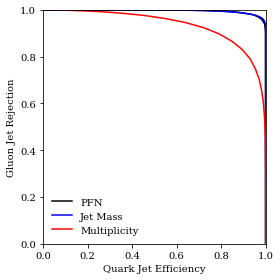

In [19]:
#Bins 1 and 2
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 256710, 34227, 51342
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 20
batch_size = 500

################################################################################

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('PFN AUC:', auc)
    print()

    # make ROC curve plot if we have matplotlib
    if plt:

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # some nicer plot settings 
        plt.rcParams['figure.figsize'] = (4,4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        # plot the ROC curves
        plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
        plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        plt.xlabel('Quark Jet Efficiency')
        plt.ylabel('Gluon Jet Rejection')

        # axes limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # make legend and show plot
        plt.legend(loc='lower left', frameon=False)
        plt.show()

Create datasets out of mass bins 2 and 3 to feed into PFN (Particle Flow Network) machine learning model

In [0]:
#Bins 2 and 3
X = np.concatenate([jet_array_2, jet_array_3])[:,:,:4]
y = np.concatenate([np.ones(len(jet_array_2)), np.zeros(len(jet_array_3))])
del jet_array_2, jet_array_3

Run PFN model on mass bins 2 and 3 to see how well model can distinguish between jets in those bins.

Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_15 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_15[0][0]              


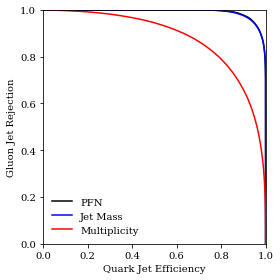

In [16]:
#Bins 2 and 3
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 480717, 64096, 96143
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 20
batch_size = 500

################################################################################

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('PFN AUC:', auc)
    print()

    # make ROC curve plot if we have matplotlib
    if plt:

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # some nicer plot settings 
        plt.rcParams['figure.figsize'] = (4,4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        # plot the ROC curves
        plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
        plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        plt.xlabel('Quark Jet Efficiency')
        plt.ylabel('Gluon Jet Rejection')

        # axes limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # make legend and show plot
        plt.legend(loc='lower left', frameon=False)
        plt.show()

Create datasets out of mass bins 3 and 4 to feed into PFN (Particle Flow Network) machine learning model

In [0]:
#Bins 3 and 4
X = np.concatenate([jet_array_3, jet_array_4])[:,:,:4]
y = np.concatenate([np.ones(len(jet_array_3)), np.zeros(len(jet_array_4))])
del jet_array_3, jet_array_4

Run PFN model on mass bins 3 and 4 to see how well model can distinguish between jets in those bins.

Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_29 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_29[0][0]              


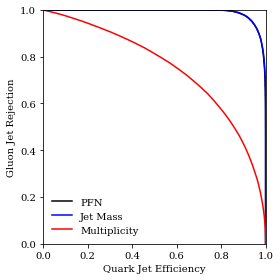

In [22]:
#Bins 3 and 4
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 342601, 45680, 68516
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 20
batch_size = 500

################################################################################

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('PFN AUC:', auc)
    print()

    # make ROC curve plot if we have matplotlib
    if plt:

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # some nicer plot settings 
        plt.rcParams['figure.figsize'] = (4,4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        # plot the ROC curves
        plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
        plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        plt.xlabel('Quark Jet Efficiency')
        plt.ylabel('Gluon Jet Rejection')

        # axes limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # make legend and show plot
        plt.legend(loc='lower left', frameon=False)
        plt.show()

Create datasets out of mass bins 4 and 5 to feed into PFN (Particle Flow Network) machine learning model

In [0]:
#Bins 4 and 5
X = np.concatenate([jet_array_4, jet_array_5])[:,:,:4]
y = np.concatenate([np.ones(len(jet_array_4)), np.zeros(len(jet_array_5))])
del jet_array_4, jet_array_5

Run PFN model on mass bins 4 and 5 to see how well model can distinguish between jets in those bins.

Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_36 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_36[0][0]              


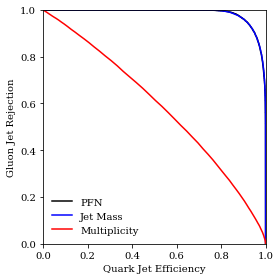

In [25]:
#Bins 4 and 5
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 146696, 19559, 29339
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 20
batch_size = 500

################################################################################

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('PFN AUC:', auc)
    print()

    # make ROC curve plot if we have matplotlib
    if plt:

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # some nicer plot settings 
        plt.rcParams['figure.figsize'] = (4,4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        # plot the ROC curves
        plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
        plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        plt.xlabel('Quark Jet Efficiency')
        plt.ylabel('Gluon Jet Rejection')

        # axes limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # make legend and show plot
        plt.legend(loc='lower left', frameon=False)
        plt.show()

Create datasets out of mass bins 5 and 6 to feed into PFN (Particle Flow Network) machine learning model

In [0]:
#Bins 5 and 6
X = np.concatenate([jet_array_5, jet_array_6])[:,:,:4]
y = np.concatenate([np.ones(len(jet_array_5)), np.zeros(len(jet_array_6))])
del jet_array_5, jet_array_6

Run PFN model on mass bins 5 and 6 to see how well model can distinguish between jets in those bins.

Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_43 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_43[0][0]              


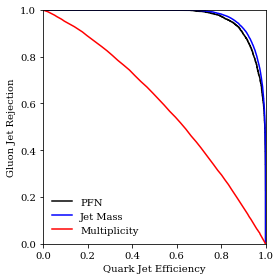

In [28]:
#Bins 5 and 6
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 57808, 7708, 11562
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 20
batch_size = 500

################################################################################

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('PFN AUC:', auc)
    print()

    # make ROC curve plot if we have matplotlib
    if plt:

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # some nicer plot settings 
        plt.rcParams['figure.figsize'] = (4,4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        # plot the ROC curves
        plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
        plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        plt.xlabel('Quark Jet Efficiency')
        plt.ylabel('Gluon Jet Rejection')

        # axes limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # make legend and show plot
        plt.legend(loc='lower left', frameon=False)
        plt.show()

Create datasets out of mass bins 6 and 7 to feed into PFN (Particle Flow Network) machine learning model

In [0]:
#Bins 6 and 7
X = np.concatenate([jet_array_6, jet_array_7])[:,:,:4]
y = np.concatenate([np.ones(len(jet_array_6)), np.zeros(len(jet_array_7))])
del jet_array_6, jet_array_7

Run PFN model on mass bins 6 and 7 to see how well model can distinguish between jets in those bins.

Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_1[0][0]           

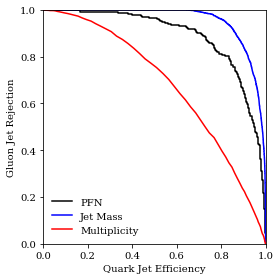

In [13]:
#Bins 6 and 7
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 16962, 2262, 3393
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 20
batch_size = 500

################################################################################

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('PFN AUC:', auc)
    print()

    # make ROC curve plot if we have matplotlib
    if plt:

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # some nicer plot settings 
        plt.rcParams['figure.figsize'] = (4,4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        # plot the ROC curves
        plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
        plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        plt.xlabel('Quark Jet Efficiency')
        plt.ylabel('Gluon Jet Rejection')

        # axes limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # make legend and show plot
        plt.legend(loc='lower left', frameon=False)
        plt.show()

Create datasets out of mass bins 7 and 8 to feed into PFN (Particle Flow Network) machine learning model

In [0]:
#Bins 7 and 8
X = np.concatenate([jet_array_7, jet_array_8])[:,:,:4]
y = np.concatenate([np.ones(len(jet_array_7)), np.zeros(len(jet_array_8))])
del jet_array_7, jet_array_8

Run PFN model on mass bins 7 and 8 to see how well model can distinguish between jets in those bins.

Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_8 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_8[0][0]               


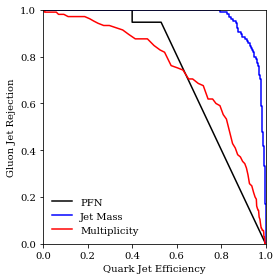

In [16]:
#Bins 7 and 8
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 2170, 289, 434
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 20
batch_size = 500

################################################################################

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('PFN AUC:', auc)
    print()

    # make ROC curve plot if we have matplotlib
    if plt:

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # some nicer plot settings 
        plt.rcParams['figure.figsize'] = (4,4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        # plot the ROC curves
        plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
        plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        plt.xlabel('Quark Jet Efficiency')
        plt.ylabel('Gluon Jet Rejection')

        # axes limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # make legend and show plot
        plt.legend(loc='lower left', frameon=False)
        plt.show()